In [1]:
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import tensorflow as tf

In [4]:
import tensorflow_datasets as tfds

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [6]:
example, metadata = tfds.load("ted_hrlr_translate/pt_to_en", with_info=True, as_supervised=True)

In [7]:
train_examples, val_examples = example["train"], example["validation"]

In [8]:
dir(train_examples)

['_GeneratorState',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_add_variable_with_custom_getter',
 '_apply_options',
 '_as_serialized_graph',
 '_buffer_size',
 '_checkpoint_dependencies',
 '_consumers',
 '_deferred_dependencies',
 '_flat_shapes',
 '_flat_structure',
 '_flat_types',
 '_functions',
 '_gather_saveables_for_checkpoint',
 '_graph',
 '_graph_attr',
 '_handle_deferred_dependencies',
 '_has_captured_ref',
 '_input_dataset',
 '_inputs',
 '_list_extra_dependencies_for_serialization',
 '_list_functions_for_serialization',
 '_lookup_d

In [9]:
train_examples.from_tensors

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.from_tensors(tensors)>

In [10]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus((en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [11]:
tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus((pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [12]:
sample_string = "Transformer is awesome."

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]


In [13]:
origin_string = tokenizer_en.decode(tokenized_string)
origin_string

'Transformer is awesome.'

In [14]:
assert sample_string == origin_string

In [15]:
for ts in tokenized_string:
    print("{} - - ->>> {}".format(ts, tokenizer_en.decode([ts])))

7915 - - ->>> T
1248 - - ->>> ran
7946 - - ->>> s
7194 - - ->>> former 
13 - - ->>> is 
2799 - - ->>> awesome
7877 - - ->>> .


In [16]:
dir(tokenizer_en)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_build_from_token_counts',
 '_byte_encode',
 '_cache_size',
 '_filename',
 '_id_to_subword',
 '_init_from_list',
 '_max_subword_len',
 '_read_lines_from_file',
 '_subword_to_id',
 '_subwords',
 '_token_to_ids',
 '_token_to_ids_cache',
 '_token_to_subwords',
 '_tokenizer',
 '_write_lines_to_file',
 'build_from_corpus',
 'decode',
 'encode',
 'load_from_file',
 'save_to_file',
 'subwords',
 'vocab_size']

In [17]:
print("en vocab size:", tokenizer_en.vocab_size)
print("pt vocab size:", tokenizer_pt.vocab_size)

en vocab size: 8087
pt vocab size: 8214


In [18]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [19]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(lang1.numpy()) + [tokenizer_pt.vocab_size + 1]
    
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(lang2.numpy()) + [tokenizer_en.vocab_size + 1]
    
    return lang1, lang2

In [20]:
MAX_LENGTH = 40

In [21]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)

In [22]:
tf.logical_and(True, True)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [23]:
def tf_encode(pt, en):
    result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en

In [24]:
train_dataset = train_examples.map(tf_encode)

In [25]:
train_dataset

<MapDataset shapes: ((None,), (None,)), types: (tf.int64, tf.int64)>

In [26]:
train_dataset = train_dataset.filter(filter_max_length)

In [27]:
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE,padded_shapes=([-1], [-1]))

流水线技术 重叠训练的预处理和模型训练步骤。当加速器正在执行训练步骤 N 时，CPU 开始准备步骤 N + 1 的数据。这样做可以将步骤时间减少到模型训练与抽取转换数据二者所需的最大时间（而不是二者时间总和）。

没有流水线技术，CPU 和 GPU/TPU 大部分时间将处于闲置状态:

In [28]:
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [29]:
val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE,padded_shapes=([-1], [-1]))

In [30]:
pt_batch, en_batch = next(iter(val_dataset))

In [31]:
pt_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8214,  342, 3032, ...,    0,    0,    0],
        [8214,   95,  198, ...,    0,    0,    0],
        [8214, 4479, 7990, ...,    0,    0,    0],
        ...,
        [8214,  584,   12, ...,    0,    0,    0],
        [8214,   59, 1548, ...,    0,    0,    0],
        [8214,  118,   34, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8087,   98,   25, ...,    0,    0,    0],
        [8087,   12,   20, ...,    0,    0,    0],
        [8087,   12, 5453, ...,    0,    0,    0],
        ...,
        [8087,   18, 2059, ...,    0,    0,    0],
        [8087,   16, 1436, ...,    0,    0,    0],
        [8087,   15,   57, ...,    0,    0,    0]])>)

## 位置编码（Positional encoding）

因为该模型并不包括任何的循环（recurrence）或卷积，所以模型添加了位置编码，为模型提供一些关于单词在句子中相对位置的信息。

位置编码向量被加到嵌入（embedding）向量中。嵌入表示一个 d 维空间的标记，在 d 维空间中有着相似含义的标记会离彼此更近。但是，嵌入并没有对在一句话中的词的相对位置进行编码。因此，当加上位置编码后，词将基于*它们含义的相似度以及它们在句子中的位置*，在 d 维空间中离彼此更近。

参看 [位置编码](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) 的 notebook 了解更多信息。计算位置编码的公式如下：

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [32]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    
    return pos * angle_rates

In [33]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)

    # 将 sin 应用于数组中的偶数索引（indices）；2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 将 cos 应用于数组中的奇数索引；2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [34]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

(1, 50, 512)


In [35]:
pos_encoding[0]

<tf.Tensor: shape=(50, 512), dtype=float32, numpy=
array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 8.41470957e-01,  5.40302277e-01,  8.21856201e-01, ...,
         1.00000000e+00,  1.03663289e-04,  1.00000000e+00],
       [ 9.09297407e-01, -4.16146845e-01,  9.36414719e-01, ...,
         1.00000000e+00,  2.07326579e-04,  1.00000000e+00],
       ...,
       [ 1.23573124e-01, -9.92335498e-01,  9.77189839e-01, ...,
         9.99987245e-01,  4.87215538e-03,  9.99988139e-01],
       [-7.68254638e-01, -6.40144348e-01,  7.31235921e-01, ...,
         9.99986708e-01,  4.97581763e-03,  9.99987602e-01],
       [-9.53752637e-01,  3.00592542e-01, -1.44026920e-01, ...,
         9.99986112e-01,  5.07947942e-03,  9.99987125e-01]], dtype=float32)>

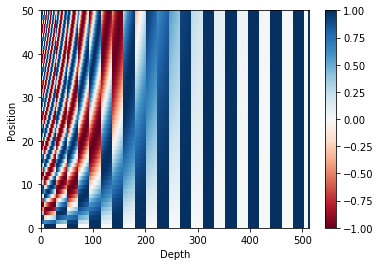

In [36]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## 遮挡（Masking）

遮挡一批序列中所有的填充标记（pad tokens）。这确保了模型不会将填充作为输入。该 mask 表明填充值 `0` 出现的位置：在这些位置 mask 输出 `1`，否则输出 `0`。

In [37]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    return seq[:, tf.newaxis, tf.newaxis, :]

In [38]:
tf.cast(tf.math.equal(1, 0), tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [39]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])

In [40]:
create_padding_mask(x)

seq shape: (3, 5)


<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

前瞻遮挡（look-ahead mask）用于遮挡一个序列中的后续标记（future tokens）。换句话说，该 mask 表明了不应该使用的条目。

这意味着要预测第三个词，将仅使用第一个和第二个词。与此类似，预测第四个词，仅使用第一个，第二个和第三个词，依此类推。

In [41]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    
    return mask

In [42]:
x = tf.random.uniform((1, 3))

In [43]:
x

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.38015103, 0.5586661 , 0.36114728]], dtype=float32)>

In [44]:
tem = create_look_ahead_mask(x.shape[1])

In [45]:
tem

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## 按比缩放的点积注意力（Scaled dot product attention）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

Transformer 使用的注意力函数有三个输入：Q（请求（query））、K（主键（key））、V（数值（value））。用于计算注意力权重的等式为：

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

点积注意力被缩小了深度的平方根倍。这样做是因为对于较大的深度值，点积的大小会增大，从而推动 softmax 函数往仅有很小的梯度的方向靠拢，导致了一种很硬的（hard）softmax。

例如，假设 `Q` 和 `K` 的均值为0，方差为1。它们的矩阵乘积将有均值为0，方差为 `dk`。因此，*`dk` 的平方根*被用于缩放（而非其他数值），因为，`Q` 和 `K` 的矩阵乘积的均值本应该为 0，方差本应该为1，这样会获得一个更平缓的 softmax。

遮挡（mask）与 -1e9（接近于负无穷）相乘。这样做是因为遮挡与缩放的 Q 和 K 的矩阵乘积相加，并在 softmax 之前立即应用。目标是将这些单元归零，因为 softmax 的较大负数输入在输出中接近于零。

- query向量：query顾名思义，是负责寻找这个字的于其他字的相关度（通过其它字的key） 
- key向量：key向量就是用来于query向量作匹配，得到相关度评分的 
- value向量：Value vectors 是实际上的字的表示, 一旦我们得到了字的相关度评分，这些表示是用来加权求和的

得到每个字的  之后，我们要得到每个字和句子中其他字的相关关系，我们只需要把这个字的query去和其他字的key作匹配，然后得到分数，最后在通过其它字的value的加权求和（权重就是哪个分数）得到这个字的最终输出。

In [46]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # 将 mask 放入到缩放的张量上
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

In [47]:
-1e9

-1000000000.0

In [48]:
import numpy as np
def softmax(x):
    x= x - np.max(x)
    exp_x = np.exp(x)
    
    softmax_x = exp_x / np.sum(exp_x)
    return softmax_x

In [49]:
softmax([1, 2, 3, 4, 5*-1e9])

array([0.0320586 , 0.08714432, 0.23688282, 0.64391426, 0.        ])

In [50]:
5*-1e9

-5000000000.0

In [51]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
    
    print("Attention weights are:")
    print(temp_attn)
    print("Output is:")
    print(temp_out)

In [52]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# 这条 `请求（query）符合第二个`主键（key）`，
# 因此返回了第二个`数值（value）`。
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


## 多头注意力（Multi-head Attention）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


多头注意力由四部分组成：
*    线性层并分拆成多头。
*    按比缩放的点积注意力。
*    多头及联。
*    最后一层线性层。

每个多头注意力块有三个输入：Q（请求）、K（主键）、V（数值）。这些输入经过线性（Dense）层，并分拆成多头。 

将上面定义的 `scaled_dot_product_attention` 函数应用于每个头（进行了广播（broadcasted）以提高效率）。注意力这步必须使用一个恰当的 mask。然后将每个头的注意力输出连接起来（用`tf.transpose` 和 `tf.reshape`），并放入最后的 `Dense` 层。

Q、K、和 V 被拆分到了多个头，而非单个的注意力头，因为多头允许模型共同注意来自不同表示空间的不同位置的信息。在分拆后，每个头部的维度减少，因此总的计算成本与有着全部维度的单个注意力头相同。

In [53]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads 

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
    
    def split_heads(self, x, batch_size):
        
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        
        return output, attention_weights

创建一个 `MultiHeadAttention` 层进行尝试。在序列中的每个位置 `y`，`MultiHeadAttention` 在序列中的所有其他位置运行所有8个注意力头，在每个位置y，返回一个新的同样长度的向量。

In [54]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)

In [55]:
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)

In [56]:
y.shape

TensorShape([1, 60, 512])

In [57]:
out, attn = temp_mha(y, k=y, q=y, mask=None)

In [58]:
out.shape

TensorShape([1, 60, 512])

In [59]:
attn.shape

TensorShape([1, 8, 60, 60])

## 点式前馈网络（Point wise feed forward network）

点式前馈网络由两层全联接层组成，两层之间有一个 ReLU 激活函数。

In [60]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation="relu"),
        tf.keras.layers.Dense(d_model)
    ])

In [61]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

### 编码器层（Encoder layer）

每个编码器层包括以下子层：

1.   多头注意力（有填充遮挡）
2.   点式前馈网络（Point wise feed forward networks）。

每个子层在其周围有一个残差连接，然后进行层归一化。残差连接有助于避免深度网络中的梯度消失问题。

每个子层的输出是 `LayerNorm(x + Sublayer(x))`。归一化是在 `d_model`（最后一个）维度完成的。Transformer 中有 N 个编码器层。

In [63]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        # (x-mean) / std,
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [64]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### 解码器层（Decoder layer）

每个解码器层包括以下子层：

1.   遮挡的多头注意力（前瞻遮挡和填充遮挡）
2.   多头注意力（用填充遮挡）。V（数值）和 K（主键）接收*编码器输出*作为输入。Q（请求）接收*遮挡的多头注意力子层的输出*。
3.   点式前馈网络

每个子层在其周围有一个残差连接，然后进行层归一化。每个子层的输出是 `LayerNorm(x + Sublayer(x))`。归一化是在 `d_model`（最后一个）维度完成的。

Transformer 中共有 N 个解码器层。

当 Q 接收到解码器的第一个注意力块的输出，并且 K 接收到编码器的输出时，注意力权重表示根据编码器的输出赋予解码器输入的重要性。换一种说法，解码器通过查看编码器输出和对其自身输出的自注意力，预测下一个词。参看按比缩放的点积注意力部分的演示。

<img src="https://tensorflow.google.cn/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

In [68]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        # v, k, q, mask
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [69]:
sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

In [70]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### 编码器（Encoder）

`编码器` 包括：
1.   输入嵌入（Input Embedding）
2.   位置编码（Positional Encoding）
3.   N 个编码器层（encoder layers）

输入经过嵌入（embedding）后，该嵌入与位置编码相加。该加法结果的输出是编码器层的输入。编码器的输出是解码器的输入。

<img src="https://tensorflow.google.cn/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

In [71]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # 将嵌入和位置编码相加。
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        
        # 为什么要乘以embedding size的开方？
        # 猜测是因为embedding matrix的初始化方式是xavier init，这种方式的方差是1/embedding size，
        # 因此乘以embedding size的开方使得embedding matrix的方差是1，在这个scale下可能更有利于embedding matrix的收敛。
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [72]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, dff=2048, input_vocab_size=8500, maximum_position_encoding=10000)

In [73]:
sample_encoder_output = sample_encoder(tf.random.uniform((64, 62)), 
                                       training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### 解码器（Decoder）
`解码器`包括：
1.   输出嵌入（Output Embedding）
2.   位置编码（Positional Encoding）
3.   N 个解码器层（decoder layers）

目标（target）经过一个嵌入后，该嵌入和位置编码相加。该加法结果是解码器层的输入。解码器的输出是最后的线性层的输入。

<img src="https://tensorflow.google.cn/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

In [74]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            # v, k, q
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

In [75]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)

output, attn = sample_decoder(tf.random.uniform((64, 26)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## 创建Transformer

Transformer 包括编码器，解码器和最后的线性层。解码器的输出是线性层的输入，返回线性层的输出。

In [77]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

In [78]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 26, 8000])

## 配置超参数（hyperparameters）

为了让本示例小且相对较快，已经减小了*num_layers、 d_model 和  dff* 的值。 

Transformer 的基础模型使用的数值为：*num_layers=6*，*d_model = 512*，*dff = 2048*。关于所有其他版本的 Transformer，请查阅[论文](https://arxiv.org/abs/1706.03762)。

Note：通过改变以下数值，您可以获得在许多任务上达到最先进水平的模型。

In [79]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## 优化器（Optimizer）

根据[论文](https://arxiv.org/abs/1706.03762)中的公式，将 Adam 优化器与自定义的学习速率调度程序（scheduler）配合使用。

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [80]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [81]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

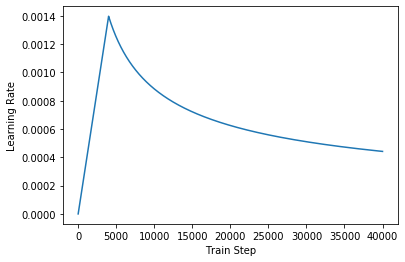

In [82]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 损失函数与指标（Loss and metrics）
由于目标序列是填充（padded）过的，因此在计算损失函数时，应用填充遮挡非常重要。

In [83]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [84]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [85]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## 训练与检查点（Training and checkpointing）

In [86]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [87]:
def create_masks(inp, tar):
    # 编码器填充遮挡
    enc_padding_mask = create_padding_mask(inp)

    # 在解码器的第二个注意力模块使用。
    # 该填充遮挡用于遮挡编码器的输出。
    dec_padding_mask = create_padding_mask(inp)

    # 在解码器的第一个注意力模块使用。
    # 用于填充（pad）和遮挡（mask）解码器获取到的输入的后续标记（future tokens）。
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [88]:
create_masks(np.array([[1,2,3,0,0]]),np.array([[4,5,6,0,0]]))

seq shape: (1, 5)
seq shape: (1, 5)
seq shape: (1, 5)


(<tf.Tensor: shape=(1, 1, 1, 5), dtype=float32, numpy=array([[[[0., 0., 0., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 5, 5), dtype=float32, numpy=
 array([[[[0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 1., 1.]]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1, 1, 5), dtype=float32, numpy=array([[[[0., 0., 0., 1., 1.]]]], dtype=float32)>)

In [89]:
checkpoint_path = "./data/checkpoints/transformer/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

目标（target）被分成了 tar_inp 和 tar_real。tar_inp 作为输入传递到解码器。`tar_real` 是位移了 1 的同一个输入：在 `tar_inp` 中的每个位置，`tar_real` 包含了应该被预测到的下一个标记（token）。

例如，`sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

Transformer 是一个自回归（auto-regressive）模型：它一次作一个部分的预测，然后使用到目前为止的自身的输出来决定下一步要做什么。

在训练过程中，本示例使用了 teacher-forcing 的方法（就像[文本生成教程](./text_generation.ipynb)中一样）。无论模型在当前时间步骤下预测出什么，teacher-forcing 方法都会将真实的输出传递到下一个时间步骤上。

当 transformer 预测每个词时，*自注意力（self-attention）*功能使它能够查看输入序列中前面的单词，从而更好地预测下一个单词。

为了防止模型在期望的输出上达到峰值，模型使用了前瞻遮挡（look-ahead mask）。

In [90]:
EPOCHS = 10

In [91]:
# 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地
# 执行。该函数专用于参数张量的精确形状。为了避免由于可变序列长度或可变
# 批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定
# 更多的通用形状。

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
  
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
    train_loss(loss)
    train_accuracy(tar_real, predictions)

葡萄牙语作为输入语言，英语为目标语言。

In [92]:
for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
  
    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

seq shape: (None, None)
seq shape: (None, None)
seq shape: (None, None)
seq shape: (None, None)
seq shape: (None, None)
seq shape: (None, None)
Epoch 1 Batch 0 Loss 4.2347 Accuracy 0.0000
Epoch 1 Batch 50 Loss 4.2199 Accuracy 0.0001
Epoch 1 Batch 100 Loss 4.1824 Accuracy 0.0074
Epoch 1 Batch 150 Loss 4.1227 Accuracy 0.0146
Epoch 1 Batch 200 Loss 4.0615 Accuracy 0.0179
Epoch 1 Batch 250 Loss 3.9898 Accuracy 0.0205
Epoch 1 Batch 300 Loss 3.9145 Accuracy 0.0229
Epoch 1 Batch 350 Loss 3.8249 Accuracy 0.0263
Epoch 1 Batch 400 Loss 3.7352 Accuracy 0.0308
Epoch 1 Batch 450 Loss 3.6605 Accuracy 0.0346
Epoch 1 Batch 500 Loss 3.5885 Accuracy 0.0378
Epoch 1 Batch 550 Loss 3.5269 Accuracy 0.0414
Epoch 1 Batch 600 Loss 3.4681 Accuracy 0.0452
Epoch 1 Batch 650 Loss 3.4087 Accuracy 0.0490
Epoch 1 Batch 700 Loss 3.3554 Accuracy 0.0530
Epoch 1 Loss 3.3529 Accuracy 0.0531
Time taken for 1 epoch: 74.84644222259521 secs

Epoch 2 Batch 0 Loss 2.3281 Accuracy 0.1010
Epoch 2 Batch 50 Loss 2.4954 Accuracy 0.1

## 评估（Evaluate）

以下步骤用于评估：

* 用葡萄牙语分词器（`tokenizer_pt`）编码输入语句。此外，添加开始和结束标记，这样输入就与模型训练的内容相同。这是编码器输入。
* 解码器输入为 `start token == tokenizer_en.vocab_size`。
* 计算填充遮挡和前瞻遮挡。
* `解码器`通过查看`编码器输出`和它自身的输出（自注意力）给出预测。
* 选择最后一个词并计算它的 argmax。
* 将预测的词连接到解码器输入，然后传递给解码器。
* 在这种方法中，解码器根据它预测的之前的词预测下一个。

Note：这里使用的模型具有较小的能力以保持相对较快，因此预测可能不太正确。要复现论文中的结果，请使用全部数据集，并通过修改上述超参数来使用基础 transformer 模型或者 transformer XL。

In [93]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]

    # 输入语句是葡萄牙语，增加开始和结束标记
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # 因为目标是英语，输入 transformer 的第一个词应该是
    # 英语的开始标记。
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # 从 seq_len 维度选择最后一个词
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 如果 predicted_id 等于结束标记，就返回结果
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights

        # 连接 predicted_id 与输出，作为解码器的输入传递到解码器。
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [94]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)
  
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # 画出注意力权重
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result)-1.5, -0.5)

        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

In [95]:
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)

    predicted_sentence = tokenizer_en.decode([i for i in result 
                                            if i < tokenizer_en.vocab_size])  

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))
  
    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

In [96]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 1)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 2)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 3)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 4)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 5)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 6)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 7)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 8)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 9)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 10)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 12)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 13)
Input: este é um problema que temos que resolver.
Predicted translation: `` `` '' and and and it 's of the right now .
Real translation: this is a problem we have to solve .


In [97]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 1)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 2)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 3)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 4)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 5)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 6)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 7)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 8)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 9)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 10)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 12)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 13)
Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: `` `` '' and and and it 's of the right now .
Real translation: and my neighboring homes heard about this idea .


In [98]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

seq shape: (1, 20)
seq shape: (1, 20)
seq shape: (1, 1)
seq shape: (1, 20)
seq shape: (1, 20)
seq shape: (1, 2)
seq shape: (1, 20)
seq shape: (1, 20)
seq shape: (1, 3)
seq shape: (1, 20)
seq shape: (1, 20)
seq shape: (1, 4)
seq shape: (1, 20)
seq shape: (1, 20)
seq shape: (1, 5)
seq shape: (1, 20)
seq shape: (1, 20)
seq shape: (1, 6)
seq shape: (1, 20)
seq shape: (1, 20)
seq shape: (1, 7)
Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: `` `` '' and the the world .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


您可以为 `plot` 参数传递不同的层和解码器的注意力模块。

seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 1)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 2)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 3)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 4)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 5)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 6)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 7)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 8)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 9)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 10)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 12)
seq shape: (1, 11)
seq shape: (1, 11)
seq shape: (1, 13)
Input: este é o primeiro livro que eu fiz.
Predicted translation: `` `` '' and and and it 's of the right now .


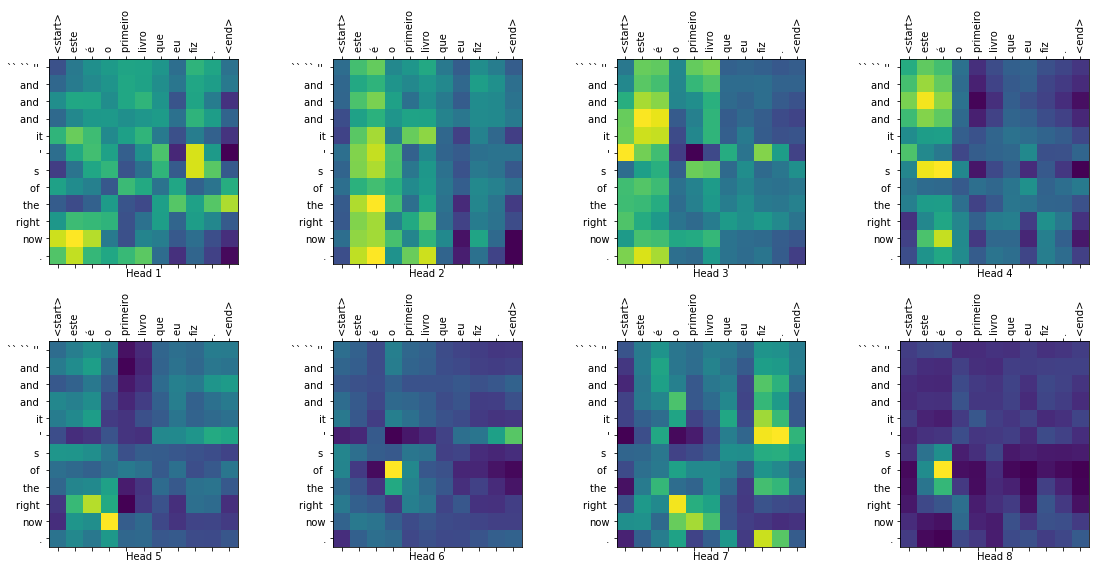

Real translation: this is the first book i've ever done.


In [99]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")